In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from PIL import Image as im

##### 0, Define the hyper parameters

In [2]:
n_epochs = 100 #Initially 3. 
batch_size_train = 16
batch_size_test = 16

##### 1, Loading training and testing data

#### Organizing images

First, we need to create a directory structure to hold our images.
The directory <em>training2</em> will hold 10 directories, corresponding to class labels.

This is so we can load the images using torchvision.datasets.ImageFolder, which expects the format described above.

In [3]:
import os

#Make training2 directory
if not os.path.exists('training2'):
    os.mkdir("training2")
#Create the subdirectories corresponding to class labels
for i in range(10):
    if not os.path.exists("training2/{:02d}".format(i+1)):
        os.mkdir("training2/{:02d}".format(i + 1))

In [4]:
import shutil

#Iterate through labels.txt, copying images from training into training2 based on their class label
file = open("labels.txt","r")
for line in file.readlines():
    text = line.strip().split("\t")
    shutil.copy("training/" + text[0], "training2/{:02d}/".format(int(text[1])))
file.close()

In [5]:
transform = transforms.Compose([transforms.Grayscale(),
                                transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

dataset = datasets.ImageFolder('training2',transform=transform)

Label : 01


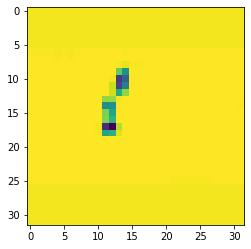

In [6]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[0])

In [7]:
#Splitting the dataset into a testing and training set
trainset,testset = random_split(dataset,[600,260])

Passing the dataset to a dataloader

In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size_test=16, shuffle=True)

##### 2 Define the model

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*8*8, 10)

    # x represents our data
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        
        return x

##### 3 Write the training function and the testing function

In [11]:
def test(model, test_loader, device):
    # evaluation, freeze 
    model.eval()
    total_num = 0
    total_correct = 0
    with torch.no_grad():
        for _, (data, target) in enumerate(test_loader):
            
            data = data.to(device)
            target = target.to(device)
            
            predict_one_hot = model(data)
            
            _, predict_label = torch.max(predict_one_hot, 1)
            
            total_correct += (predict_label == target).sum().item()
            total_num += target.size(0)
        
    return (total_correct / total_num)
            

In [12]:
def train(model, train_loader, test_loader, num_epoch, learning_rate, momentum, device):
    train_losses = []
    
    # 1, define optimizer
    optimizer = optim.Adam(network.parameters()) #Using default learning rate of 1e-3
    
    for epoch in tqdm(range(num_epoch)):
        # train the model
        model.train()
        
        for i, (data, target) in enumerate(train_loader):
            
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            
            # 2, forward
            output = network(data)
            
            
            # 3, calculate the loss
            loss = F.cross_entropy(output, target)
            
            # 4, backward
            loss.backward()
            
            
            optimizer.step()
            
        # evaluate the accuracy on test data for each epoch
        accuracy = test(model, test_loader, device)
        print('accuracy', accuracy)
        
        
    # 5, save model
    

In [13]:
device0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# use cpu if you do not have gpu installed in your computer
network = Net().to(device0)
train(model=network, train_loader=trainloader, test_loader=testloader, num_epoch=n_epochs, learning_rate=learning_rate, momentum=momentum, device=device0)

  1%|▍                                          | 1/100 [00:01<02:49,  1.71s/it]

accuracy 0.12692307692307692


  2%|▊                                          | 2/100 [00:03<02:36,  1.59s/it]

accuracy 0.12307692307692308


  3%|█▎                                         | 3/100 [00:04<02:33,  1.58s/it]

accuracy 0.25384615384615383


  4%|█▋                                         | 4/100 [00:06<02:35,  1.62s/it]

accuracy 0.36153846153846153


  5%|██▏                                        | 5/100 [00:08<02:31,  1.59s/it]

accuracy 0.34615384615384615


  6%|██▌                                        | 6/100 [00:09<02:33,  1.64s/it]

accuracy 0.36923076923076925


  7%|███                                        | 7/100 [00:11<02:34,  1.66s/it]

accuracy 0.43846153846153846


  8%|███▍                                       | 8/100 [00:13<02:32,  1.66s/it]

accuracy 0.46923076923076923


  9%|███▊                                       | 9/100 [00:14<02:29,  1.64s/it]

accuracy 0.4346153846153846


 10%|████▏                                     | 10/100 [00:16<02:27,  1.64s/it]

accuracy 0.4807692307692308


 11%|████▌                                     | 11/100 [00:17<02:25,  1.64s/it]

accuracy 0.5192307692307693


 12%|█████                                     | 12/100 [00:19<02:27,  1.67s/it]

accuracy 0.4307692307692308


 13%|█████▍                                    | 13/100 [00:21<02:27,  1.70s/it]

accuracy 0.5576923076923077


 14%|█████▉                                    | 14/100 [00:23<02:23,  1.67s/it]

accuracy 0.5538461538461539


 15%|██████▎                                   | 15/100 [00:24<02:19,  1.64s/it]

accuracy 0.5384615384615384


 16%|██████▋                                   | 16/100 [00:26<02:18,  1.64s/it]

accuracy 0.5423076923076923


 17%|███████▏                                  | 17/100 [00:27<02:17,  1.65s/it]

accuracy 0.5423076923076923


 18%|███████▌                                  | 18/100 [00:29<02:17,  1.67s/it]

accuracy 0.5923076923076923


 19%|███████▉                                  | 19/100 [00:31<02:17,  1.70s/it]

accuracy 0.5846153846153846


 20%|████████▍                                 | 20/100 [00:33<02:13,  1.67s/it]

accuracy 0.5884615384615385


 21%|████████▊                                 | 21/100 [00:34<02:10,  1.65s/it]

accuracy 0.6192307692307693


 22%|█████████▏                                | 22/100 [00:36<02:09,  1.67s/it]

accuracy 0.5923076923076923


 23%|█████████▋                                | 23/100 [00:38<02:08,  1.67s/it]

accuracy 0.6076923076923076


 24%|██████████                                | 24/100 [00:39<02:09,  1.70s/it]

accuracy 0.6423076923076924


 25%|██████████▌                               | 25/100 [00:41<02:07,  1.71s/it]

accuracy 0.6076923076923076


 26%|██████████▉                               | 26/100 [00:43<02:10,  1.76s/it]

accuracy 0.6653846153846154


 27%|███████████▎                              | 27/100 [00:45<02:10,  1.79s/it]

accuracy 0.6423076923076924


 28%|███████████▊                              | 28/100 [00:46<02:02,  1.71s/it]

accuracy 0.6576923076923077


 29%|████████████▏                             | 29/100 [00:48<01:57,  1.65s/it]

accuracy 0.6615384615384615


 30%|████████████▌                             | 30/100 [00:50<01:58,  1.69s/it]

accuracy 0.6615384615384615


 31%|█████████████                             | 31/100 [00:51<01:58,  1.72s/it]

accuracy 0.6576923076923077


 32%|█████████████▍                            | 32/100 [00:53<01:59,  1.75s/it]

accuracy 0.6730769230769231


 33%|█████████████▊                            | 33/100 [00:55<01:58,  1.77s/it]

accuracy 0.6576923076923077


 34%|██████████████▎                           | 34/100 [00:57<01:57,  1.79s/it]

accuracy 0.65


 35%|██████████████▋                           | 35/100 [00:59<01:56,  1.80s/it]

accuracy 0.6692307692307692


 36%|███████████████                           | 36/100 [01:00<01:54,  1.80s/it]

accuracy 0.6692307692307692


 37%|███████████████▌                          | 37/100 [01:02<01:53,  1.80s/it]

accuracy 0.676923076923077


 38%|███████████████▉                          | 38/100 [01:04<01:52,  1.81s/it]

accuracy 0.6653846153846154


 39%|████████████████▍                         | 39/100 [01:06<01:50,  1.81s/it]

accuracy 0.6653846153846154


 40%|████████████████▊                         | 40/100 [01:08<01:48,  1.81s/it]

accuracy 0.6807692307692308


 41%|█████████████████▏                        | 41/100 [01:10<01:47,  1.82s/it]

accuracy 0.6692307692307692


 42%|█████████████████▋                        | 42/100 [01:11<01:45,  1.82s/it]

accuracy 0.6653846153846154


 43%|██████████████████                        | 43/100 [01:13<01:43,  1.82s/it]

accuracy 0.6653846153846154


 44%|██████████████████▍                       | 44/100 [01:15<01:42,  1.83s/it]

accuracy 0.6730769230769231


 45%|██████████████████▉                       | 45/100 [01:17<01:43,  1.88s/it]

accuracy 0.6730769230769231


 46%|███████████████████▎                      | 46/100 [01:19<01:40,  1.86s/it]

accuracy 0.6692307692307692


 47%|███████████████████▋                      | 47/100 [01:21<01:36,  1.82s/it]

accuracy 0.6615384615384615


 48%|████████████████████▏                     | 48/100 [01:22<01:33,  1.80s/it]

accuracy 0.6807692307692308


 49%|████████████████████▌                     | 49/100 [01:24<01:30,  1.78s/it]

accuracy 0.6961538461538461


 50%|█████████████████████                     | 50/100 [01:26<01:28,  1.77s/it]

accuracy 0.6730769230769231


 51%|█████████████████████▍                    | 51/100 [01:28<01:26,  1.76s/it]

accuracy 0.7


 52%|█████████████████████▊                    | 52/100 [01:29<01:23,  1.75s/it]

accuracy 0.6692307692307692


 53%|██████████████████████▎                   | 53/100 [01:31<01:21,  1.74s/it]

accuracy 0.6846153846153846


 54%|██████████████████████▋                   | 54/100 [01:33<01:19,  1.74s/it]

accuracy 0.6730769230769231


 55%|███████████████████████                   | 55/100 [01:34<01:18,  1.74s/it]

accuracy 0.676923076923077


 56%|███████████████████████▌                  | 56/100 [01:36<01:16,  1.74s/it]

accuracy 0.6807692307692308


 57%|███████████████████████▉                  | 57/100 [01:38<01:14,  1.74s/it]

accuracy 0.6730769230769231


 58%|████████████████████████▎                 | 58/100 [01:40<01:12,  1.73s/it]

accuracy 0.676923076923077


 59%|████████████████████████▊                 | 59/100 [01:41<01:11,  1.73s/it]

accuracy 0.6923076923076923


 60%|█████████████████████████▏                | 60/100 [01:43<01:09,  1.74s/it]

accuracy 0.6653846153846154


 61%|█████████████████████████▌                | 61/100 [01:45<01:07,  1.73s/it]

accuracy 0.6807692307692308


 62%|██████████████████████████                | 62/100 [01:47<01:05,  1.74s/it]

accuracy 0.6923076923076923


 63%|██████████████████████████▍               | 63/100 [01:48<01:05,  1.77s/it]

accuracy 0.6923076923076923


 64%|██████████████████████████▉               | 64/100 [01:50<01:04,  1.78s/it]

accuracy 0.6884615384615385


 65%|███████████████████████████▎              | 65/100 [01:52<01:02,  1.79s/it]

accuracy 0.6807692307692308


 66%|███████████████████████████▋              | 66/100 [01:54<01:01,  1.80s/it]

accuracy 0.7


 67%|████████████████████████████▏             | 67/100 [01:56<00:59,  1.81s/it]

accuracy 0.6807692307692308


 68%|████████████████████████████▌             | 68/100 [01:58<00:57,  1.81s/it]

accuracy 0.676923076923077


 69%|████████████████████████████▉             | 69/100 [01:59<00:56,  1.81s/it]

accuracy 0.6961538461538461


 70%|█████████████████████████████▍            | 70/100 [02:01<00:54,  1.82s/it]

accuracy 0.6884615384615385


 71%|█████████████████████████████▊            | 71/100 [02:03<00:52,  1.82s/it]

accuracy 0.6961538461538461


 72%|██████████████████████████████▏           | 72/100 [02:05<00:50,  1.82s/it]

accuracy 0.6884615384615385


 73%|██████████████████████████████▋           | 73/100 [02:07<00:49,  1.82s/it]

accuracy 0.7076923076923077


 74%|███████████████████████████████           | 74/100 [02:08<00:47,  1.81s/it]

accuracy 0.6961538461538461


 75%|███████████████████████████████▌          | 75/100 [02:10<00:44,  1.78s/it]

accuracy 0.6961538461538461


 76%|███████████████████████████████▉          | 76/100 [02:12<00:42,  1.76s/it]

accuracy 0.7038461538461539


 77%|████████████████████████████████▎         | 77/100 [02:14<00:40,  1.78s/it]

accuracy 0.7038461538461539


 78%|████████████████████████████████▊         | 78/100 [02:16<00:39,  1.80s/it]

accuracy 0.7076923076923077


 79%|█████████████████████████████████▏        | 79/100 [02:17<00:37,  1.81s/it]

accuracy 0.7115384615384616


 80%|█████████████████████████████████▌        | 80/100 [02:19<00:36,  1.80s/it]

accuracy 0.6923076923076923


 81%|██████████████████████████████████        | 81/100 [02:21<00:33,  1.77s/it]

accuracy 0.6884615384615385


 82%|██████████████████████████████████▍       | 82/100 [02:23<00:31,  1.76s/it]

accuracy 0.6884615384615385


 83%|██████████████████████████████████▊       | 83/100 [02:24<00:29,  1.76s/it]

accuracy 0.6923076923076923


 84%|███████████████████████████████████▎      | 84/100 [02:26<00:28,  1.75s/it]

accuracy 0.7


 85%|███████████████████████████████████▋      | 85/100 [02:28<00:26,  1.75s/it]

accuracy 0.7076923076923077


 86%|████████████████████████████████████      | 86/100 [02:30<00:24,  1.74s/it]

accuracy 0.7


 87%|████████████████████████████████████▌     | 87/100 [02:31<00:22,  1.72s/it]

accuracy 0.7038461538461539


 88%|████████████████████████████████████▉     | 88/100 [02:33<00:19,  1.65s/it]

accuracy 0.6884615384615385


 89%|█████████████████████████████████████▍    | 89/100 [02:34<00:17,  1.60s/it]

accuracy 0.7192307692307692


 90%|█████████████████████████████████████▊    | 90/100 [02:36<00:16,  1.67s/it]

accuracy 0.7076923076923077


 91%|██████████████████████████████████████▏   | 91/100 [02:38<00:15,  1.72s/it]

accuracy 0.7115384615384616


 92%|██████████████████████████████████████▋   | 92/100 [02:40<00:14,  1.75s/it]

accuracy 0.7038461538461539


 93%|███████████████████████████████████████   | 93/100 [02:42<00:12,  1.78s/it]

accuracy 0.7153846153846154


 94%|███████████████████████████████████████▍  | 94/100 [02:43<00:10,  1.80s/it]

accuracy 0.7076923076923077


 95%|███████████████████████████████████████▉  | 95/100 [02:45<00:09,  1.81s/it]

accuracy 0.7038461538461539


 96%|████████████████████████████████████████▎ | 96/100 [02:47<00:07,  1.82s/it]

accuracy 0.7038461538461539


 97%|████████████████████████████████████████▋ | 97/100 [02:49<00:05,  1.83s/it]

accuracy 0.7038461538461539


 98%|█████████████████████████████████████████▏| 98/100 [02:50<00:03,  1.74s/it]

accuracy 0.7


 99%|█████████████████████████████████████████▌| 99/100 [02:52<00:01,  1.67s/it]

accuracy 0.6923076923076923


100%|█████████████████████████████████████████| 100/100 [02:53<00:00,  1.74s/it]

accuracy 0.7115384615384616


### Saving the model

In [14]:
torch.save(network, './Final_Model.pt') 